In [4]:
import numpy as np
from scipy.io import loadmat
from matplotlib import pyplot as plt
%matplotlib inline
import imp
import time
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import linkage
__DEBUG__ = False

In [2]:
'''Loading data'''
Xs = loadmat('JSMF-nips/nips_N-5000_train.mat')
# normalize it
# for i in range(Xs.shape[-1]):
#     Xs[...,i] = Xs[...,i] / np.linalg.norm(Xs[...,i], axis=1)[:,np.newaxis]
print Xs.keys()

EPSILON = 1e-8

['C', 'D', '__header__', '__globals__', '__version__', 'D2']


In [5]:
X_raw = loadmat('X_nips_5iter_20topics.mat')['X']

X = X_raw / np.linalg.norm(X_raw,axis=1)[:,np.newaxis]
print X.shape

(5000, 20)


In [16]:
def find_negative_dot_product_bf(X):
    h, _ = X.shape
    ret = np.zeros((h,h))
    start_time = time.time()
    neg_entry = 0
    for i in range(h):
        for j in range(h):
            dotp = np.dot(X[i,:],X[j,:])
            if dotp < 0:
                neg_entry += 1
                ret[i,j] = dotp
    end_time = time.time()
    print("Compute {}*{} dot products in {} seconds, found {} neg entries"\
          .format(h,h,end_time-start_time, neg_entry))
    return ret

bf_result = find_negative_dot_product_bf(X)

Compute 5000*5000 dot products in 49.1665449142 seconds, found 491936 neg entries


679


(array([ 3031.,   685.,   510.,   361.,   198.,   120.,    57.,    23.,
           10.,     5.]),
 array([   0. ,   77.5,  155. ,  232.5,  310. ,  387.5,  465. ,  542.5,
         620. ,  697.5,  775. ]),
 <a list of 10 Patch objects>)

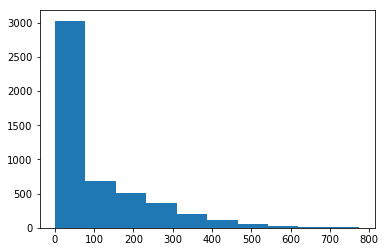

In [25]:
''' collect statistics about how many neg entries per row'''
bf_result[bf_result<0] = 1
nnegs = np.sum(bf_result, axis=0)
print len(np.where(nnegs>250)[0])
plt.hist(nnegs)

In [26]:
links = linkage(X, method='single')
links.shape

(4999, 4)

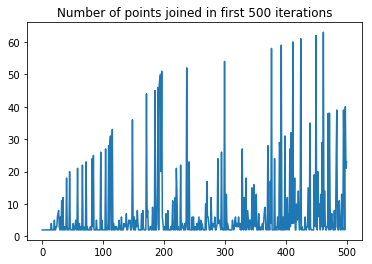

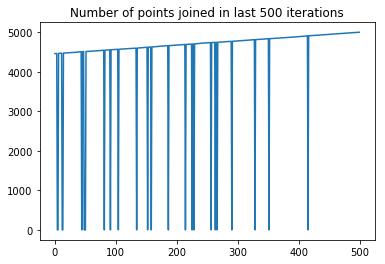

In [27]:
# show the last few joined pairs
plt.figure()
plt.title('Number of points joined in first 500 iterations')
plt.plot(links[:500, -1])

plt.figure()
plt.title('Number of points joined in last 500 iterations')
plt.plot(links[-500:, -1])

In [39]:
'''find the last few incorporated points'''
merged_idx = []
nneg_entries = []
for i in range(4999)[::-1]:
    if links[i, -1] == 2:
        merged_idx.append(i)
        nneg_entries.append(nnegs[i])
len(merged_idx)

887

844
43
14


(array([ 21.,   2.,   4.,   1.,   3.,   3.,   6.,   2.,   0.,   1.]),
 array([   0. ,   54.2,  108.4,  162.6,  216.8,  271. ,  325.2,  379.4,
         433.6,  487.8,  542. ]),
 <a list of 10 Patch objects>)

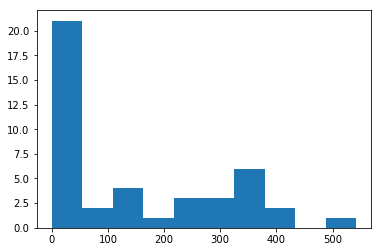

In [52]:
from bisect import bisect_left
k = bisect_left(merged_idx[::-1], 4000)
print k

sliced = nneg_entries[:-k]
print len(sliced)
print len([x for x in sliced if x > 250])
plt.hist(sliced)